In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [3]:
# helper functions for log parsing

def pass_no_pass(lines):
    for line in lines:
        if "PASSED" in line:
            return True
        elif "FAILED" in line:
            return False
    return

def parse_fp_for_int_diff(lines):
    vals = {'expected': [], 'actual': []}
    delimiters = [" ", "\n"]
    for i in range(len(lines)):
        if "INT" in lines[i]:
            for delimiter in delimiters:
                line = " ".join(lines[i+1].split(delimiter))
            split = list(map(int, line.split()))
            if ("Expected value of" in lines[i]) and ("in" not in lines[i]):
                # print(lines[i])
                vals['expected'].append(split)
            elif "Last value of" in lines[i]:
                # print(lines[i])
                vals['actual'].append(split)

    diffs = []
    for i in range(len(vals['actual'])):
        for j in range(len(vals['actual'][i])):
            if vals['expected'][i][j] != vals['actual'][i][j]:
                diffs.append(int(vals['expected'][i][j]) - int(vals['actual'][i][j]))
    return diffs

In [170]:
# create csv of testing logs
# change bool to generate csv if not created
gen_csv = False

def generate_csv():

    df = pd.DataFrame(columns=["kind", "run", "log", "lines", "time", "name", "path", "iters", "expected_vs_actual", "diff_count", "passed"])

    for filename in glob.iglob('**', recursive=True):
        # skip exceptions, keep .txts with logs
        if "log" not in filename or filename[-4:] != ".txt" or "exception" in filename:
            continue
        tmp = filename.split('/')
        if not len(tmp) - 1:
            continue
        fp = open(filename, 'r')
        lines = fp.readlines()
        fp.close()

        kind, name = tmp[0], tmp[-1]

        # TODO: something with GXL logs
        if kind == "gxld":
            continue

        # get iteration count
        iter = [line for line in lines if "Exited" in line][0].split()[-1]
        # get count of i/o matches
        int_diff = parse_fp_for_int_diff(lines)
        # get pass/fail
        passed = pass_no_pass(lines)


        # parse datetime from file name
        try:
            time = datetime.strptime(filename[-21:-4], '%Y%m%d_%H-%M-%S') # everything but GXLD logs
        except Exception:
            try:
                time = datetime.strptime(filename[-18:-4], '%m-%d-%y_%H-%M') # specifically for GXLD logs
            except Exception as e:
                raise(e)
        
        # get 'run' and 'log' numbers
        runlog = name.split('_')[2]
        run, log = [int(x) for x in runlog.split('run')[-1].split('log')]

        row = {"kind": kind, "run":run, "log": log, "lines": len(lines), "iters": int(iter), "time": time, "name": name,\
            "path": filename, "expected_vs_actual": int_diff, "diff_count": len(int_diff), "passed": passed}
        if df.name.str.contains(name).any():
            continue
        else:
            df.loc[len(df), :] = row
    df = df.sort_values(by=['kind', 'run', 'log']).reset_index(drop=True)
    df = df.astype({"time": "datetime64[ns]"})
    df = df.sort_values(by='time')
    df.to_csv("./results.csv", index=False)
if gen_csv:
    generate_csv()
logs = pd.read_csv("./results.csv")
logs = logs.astype({"time": "datetime64[ns]"})
tamu = pd.read_excel("./GSI_TAMU_202311_scrubbed.xlsx", skiprows=1)
tamu.columns = tamu.columns.str.replace(' ', '_').str.lower()
tamu = tamu.drop(len(tamu) - 1)

In [238]:
tamu

,run_number,run_start_date_and_time,run_stop,duration_of_the_run,selected_beam,effective_let_(mevcm2/mg),effective_fluence_(ions/cm2),average_flux_(ions/(cm2s)),pcb_-_dut,dut_thickness_(um),test_mode,pre-run_notes,main_rail_(12v)_i_(a),pause_#,pause_notes,pause_valid?,run_accumulated_fluence\n(ions/cm2),flunece_check,pause_fluence_(ions/cm2),requested_flus,highest_observed_12v_rail_current_i_(a),sefi_type,mitigation_applied_end_of_pause,run_notes/_mitigation_steps,valid_for_dsee,dut\ndsee_observed?,valid_for_seu,seu_count_(16-bit_word_errors),stuck_bits,valid_for_see,sefi_description,device_sefi
0,1,2023-11-12 17:56:35,2023-11-12 18:41:25,00:44:50 (+ 0 days),15.0 MeV/u 63Cu @ K500,24.6,100600.0,988.00,120000A,64.147778,L1 Static,Low airflow for cooling,NaN,1.0,Pausing to get upset numbers,1.0,49900.0,PAUSE,49900.0,1000.0,NaN,"APU marked ""in-use""",Card reboot,"Saw lots of bit flips, re-writing caused the A...",1.0,0.0,1.0,3055,0.0,1.0,APU lockup,??
1,1,2023-11-12 17:56:35,2023-11-12 18:41:25,00:44:50 (+ 0 days),15.0 MeV/u 63Cu @ K500,24.6,100600.0,988.00,120000A,64.147778,L1 Static,NaN,NaN,2.0,Pausing to get upset numbers,1.0,101000.0,PASS,51100.0,1000.0,NaN,"APU marked ""in-use""",Server reboot,Saw same lockup. This time able to reload befo...,1.0,0.0,1.0,3237,0.0,1.0,APU lockup,??
2,2,2023-11-12 18:43:51,2023-11-12 18:55:52,00:12:01 (+ 0 days),15.0 MeV/u 63Cu @ K500,24.6,100200.0,1002.00,120000A,64.147778,MMB Static,458751 errors present to start from the test S...,NaN,1.0,NaN,1.0,50300.0,PAUSE,50300.0,1000.0,NaN,NaN,NaN,Didn't hang after quitting this time,1.0,0.0,1.0,TBD,0.0,1.0,NaN,0
3,2,2023-11-12 18:43:51,2023-11-12 18:55:52,00:12:01 (+ 0 days),15.0 MeV/u 63Cu @ K500,24.6,100200.0,1002.00,120000A,64.147778,MMB Static,458751 errors present to start from the test S...,NaN,2.0,NaN,1.0,100000.0,PASS,49700.0,1000.0,NaN,NaN,NaN,Didn't hang after quitting this time,1.0,0.0,1.0,TBD,0.0,1.0,NaN,0
4,3,2023-11-12 19:03:22,2023-11-12 19:13:50,00:10:28 (+ 0 days),15.0 MeV/u 63Cu @ K500,24.6,4030.0,912.50,120000A,64.147778,L1 Dynamic Read,NaN,NaN,1.0,Invalidating this pause as the error count was...,0.0,4030.0,PASS,4030.0,1000.0,NaN,NaN,NaN,Saw a bunch on transient data errors in the re...,1.0,0.0,0.0,NaN,0.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,26,2023-11-13 05:08:54,2023-11-13 05:29:44,00:20:50 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.0,612.5,16.06,120000A,64.147778,GXLB (KNN),NaN,NaN,5.0,NaN,1.0,533.0,PAUSE,96.0,20.0,NaN,KNN Test Fail,Card reboot,"Saw the mismatch distance error again, failed ...",1.0,0.0,0.0,NaN,0.0,1.0,NaN,1
75,26,2023-11-13 05:08:54,2023-11-13 05:29:44,00:20:50 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.0,612.5,16.06,120000A,64.147778,GXLB (KNN),NaN,NaN,6.0,NaN,1.0,612.0,PASS,79.0,20.0,NaN,Runtime error,Card reboot,"Seems like it's running fast, seeing a runtime...",1.0,0.0,0.0,NaN,0.0,1.0,NaN,1
76,27,2023-11-13 05:54:48,2023-11-13 06:00:18,00:05:30 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.0,6264000.0,50600.00,120000A,64.147778,Idle SEL,"Turning down the airflow for DSEL testing, mon...",1.54,1.0,Running at ~45C,1.0,6260000.0,PASS,6260000.0,50000.0,1.54,NaN,Full power cycle,Current SW finally stopped. Paused to try and ...,1.0,0.0,0.0,NaN,NaN,0.0,NaN,1
77,28,2023-11-13 06:12:33,2023-11-13 06:13:54,00:01:21 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.0,3806000.0,50250.00,120000A,64.147778,Idle SEL,"Turning down the airflow for DSEL testing, mon...",1.54,1.0,Running at ~45C,1.0,3810000.0,PASS,3810000.0,50000.0,1.54,NaN,Full power cycle,Hit target fluence and checking functionality,1.0,0.0,0.0,NaN,NaN,0.0,NaN,1


In [239]:
tamu[tamu.test_mode == "L1 Static"]

,run_number,run_start_date_and_time,run_stop,duration_of_the_run,selected_beam,effective_let_(mevcm2/mg),effective_fluence_(ions/cm2),average_flux_(ions/(cm2s)),pcb_-_dut,dut_thickness_(um),test_mode,pre-run_notes,main_rail_(12v)_i_(a),pause_#,pause_notes,pause_valid?,run_accumulated_fluence\n(ions/cm2),flunece_check,pause_fluence_(ions/cm2),requested_flus,highest_observed_12v_rail_current_i_(a),sefi_type,mitigation_applied_end_of_pause,run_notes/_mitigation_steps,valid_for_dsee,dut\ndsee_observed?,valid_for_seu,seu_count_(16-bit_word_errors),stuck_bits,valid_for_see,sefi_description,device_sefi
0,1,2023-11-12 17:56:35,2023-11-12 18:41:25,00:44:50 (+ 0 days),15.0 MeV/u 63Cu @ K500,24.60,100600.0,988.0,120000A,64.147778,L1 Static,Low airflow for cooling,NaN,1.0,Pausing to get upset numbers,1.0,49900.0,PAUSE,49900.0,1000.0,NaN,"APU marked ""in-use""",Card reboot,"Saw lots of bit flips, re-writing caused the A...",1.0,0.0,1.0,3055,0.0,1.0,APU lockup,??
1,1,2023-11-12 17:56:35,2023-11-12 18:41:25,00:44:50 (+ 0 days),15.0 MeV/u 63Cu @ K500,24.60,100600.0,988.0,120000A,64.147778,L1 Static,NaN,NaN,2.0,Pausing to get upset numbers,1.0,101000.0,PASS,51100.0,1000.0,NaN,"APU marked ""in-use""",Server reboot,Saw same lockup. This time able to reload befo...,1.0,0.0,1.0,3237,0.0,1.0,APU lockup,??
27,13,2023-11-12 23:57:49,2023-11-12 23:58:45,00:00:56 (+ 0 days),15.0 MeV/u 40Ar @ K500,9.75,100700.0,10690.0,120000A,64.147778,L1 Static,NaN,NaN,1.0,NaN,1.0,101000.0,PASS,101000.0,10000.0,NaN,"APU marked ""in-use""",Server reboot,Tried card reboot and failed trying server reboot,1.0,0.0,1.0,3319,0.0,1.0,NaN,??
39,17,2023-11-13 01:13:39,2023-11-13 01:14:59,00:01:20 (+ 0 days),15.0 MeV/u 20Ne @ K500,3.05,111200.0,11580.0,120000A,64.147778,L1 Static,NaN,NaN,1.0,Pausing to get upset numbers,1.0,111000.0,PASS,111000.0,10000.0,NaN,NaN,Card reboot,Failed diag,1.0,0.0,1.0,1658,0.0,1.0,NaN,??
49,20,2023-11-13 02:41:28,2023-11-13 02:42:57,00:01:29 (+ 0 days),15.0 MeV/u 14N @ K500,1.43,107500.0,11540.0,120000A,64.147778,L1 Static,NaN,NaN,1.0,NaN,1.0,108000.0,PASS,108000.0,10000.0,NaN,NaN,Card reboot,Failed diag,1.0,0.0,1.0,908,0.0,1.0,NaN,0
61,23,2023-11-13 04:33:41,2023-11-13 04:40:41,00:07:00 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.00,10920.0,1072.0,120000A,64.147778,L1 Static,NaN,NaN,1.0,NaN,1.0,10900.0,PASS,10900.0,1000.0,NaN,NaN,Full power cycle,"Not responsive after stopping to check bits, F...",1.0,0.0,0.0,0,0.0,0.0,NaN,1
62,24,2023-11-13 04:49:47,2023-11-13 05:00:16,00:10:29 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.00,15130.0,151.8,120000A,64.147778,L1 Static,NaN,NaN,1.0,NaN,1.0,1190.0,PAUSE,1190.0,100.0,NaN,NaN,NaN,Checking,1.0,0.0,1.0,NaN,0.0,1.0,NaN,0
63,24,2023-11-13 04:49:47,2023-11-13 05:00:16,00:10:29 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.00,15130.0,151.8,120000A,64.147778,L1 Static,NaN,NaN,2.0,NaN,1.0,2540.0,PAUSE,1350.0,100.0,NaN,NaN,NaN,Checking,1.0,0.0,1.0,NaN,0.0,1.0,NaN,0
64,24,2023-11-13 04:49:47,2023-11-13 05:00:16,00:10:29 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.00,15130.0,151.8,120000A,64.147778,L1 Static,NaN,NaN,3.0,NaN,1.0,5080.0,PAUSE,2540.0,100.0,NaN,NaN,NaN,Checking,1.0,0.0,1.0,NaN,0.0,1.0,NaN,0
65,24,2023-11-13 04:49:47,2023-11-13 05:00:16,00:10:29 (+ 0 days),15.0 MeV/u 129Xe @ K500,67.00,15130.0,151.8,120000A,64.147778,L1 Static,NaN,NaN,4.0,NaN,1.0,10000.0,PAUSE,4920.0,100.0,NaN,NaN,NaN,Checking,1.0,0.0,1.0,NaN,0.0,1.0,NaN,0


In [235]:
logs[logs.kind == "l1_static"].diff_count.reset_index(drop=True)

0         0
1        62
2        62
3        62
4         0
5         0
6        91
7        91
8     32768
9         0
10        0
11    32768
12    32766
13        0
14       51
15       51
16        0
17        0
Name: diff_count, dtype: int64

Text(0.5, 1.0, 'Log files vs Excel / L1 Static ONLY')

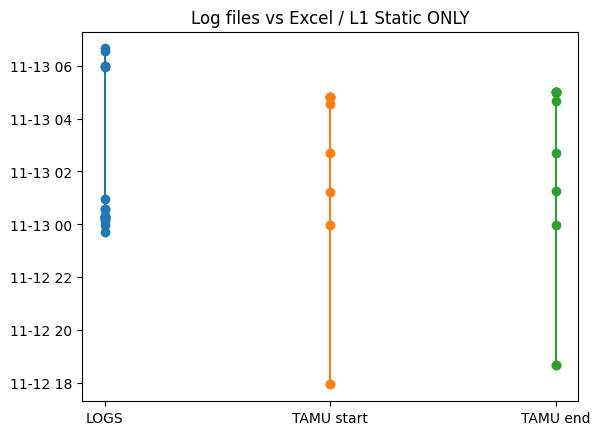

In [176]:
x = logs[logs.kind == 'l1_static'].reset_index(drop=True)
y = tamu[tamu.test_mode == "L1 Static"].reset_index(drop=True)
fig, ax = plt.subplots()
ax.plot(['LOGS']*x.shape[0], x['time'], marker='o')
ax.plot(["TAMU start"]*y.shape[0], y["run_start_date_and_time"], marker='o')
ax.plot(["TAMU end"]*y.shape[0], y['run_stop'], marker='o')
ax.set_title("Log files vs Excel / L1 Static ONLY")

<Axes: xlabel='time'>

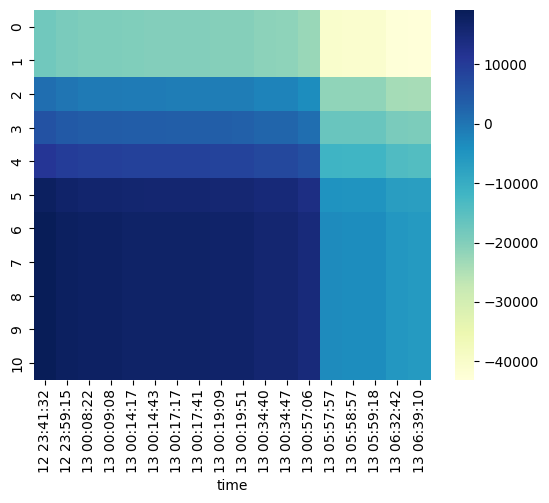

In [228]:
tmp = pd.DataFrame(columns=x.time.dt.strftime("%d %H:%M:%S"))
for row in y.run_stop:
    tmp.loc[len(tmp), :] = list(map(lambda x: int(x.total_seconds()), row - x.time))
tmp = tmp.astype('int')
sns.heatmap(tmp, cmap="YlGnBu", annot=False, )

In [224]:
tmp.iloc[:, 0]

0    -18007
1    -18007
2      1033
3      5607
4     10885
5     17949
6     19124
7     19124
8     19124
9     19124
10    19124
Name: 2023-11-12 23:41:32, dtype: int64

In [203]:
y.run_stop

0    2023-11-12 18:41:25
1    2023-11-12 18:41:25
2    2023-11-12 23:58:45
3    2023-11-13 01:14:59
4    2023-11-13 02:42:57
5    2023-11-13 04:40:41
6    2023-11-13 05:00:16
7    2023-11-13 05:00:16
8    2023-11-13 05:00:16
9    2023-11-13 05:00:16
10   2023-11-13 05:00:16
Name: run_stop, dtype: datetime64[ns]

In [7]:
masks = []
for path in df[df.kind == "mmb_dynamic"].path:
    lines = open(path).read().split('\n')
    mask, mask_bool = [], False
    for line in lines:
        if "mask" in line:
            mask_bool = True
            continue
        elif ("SECTION" in line) or (line == ""):
            mask_bool = False
        if mask_bool:
            mask.append(line)
    if len(mask): masks.append(mask)

In [114]:
f = open('/home/jacob/radTestLogBackup/mmb_static/log_staticMMBtest_run2log4_20231113_06-13-00.txt')
lines = f.read().split("\n")
f.close()

In [121]:
expected, actual = [], []
delimiters = [" ", "\n"]
for i in range(len(lines)):
    if "INT" in lines[i]:
        for delimiter in delimiters:
            line = " ".join(lines[i+1].split(delimiter))
        split = list(map(int, line.split()))
        split = list(map(lambda x: '{0:016b}'.format(x), split))
        if ("Expected value of" in lines[i]) and ("in" not in lines[i]):
            # print(lines[i])
            expected.append(split)
        elif "Last value of" in lines[i]:
            # print(lines[i])
            actual.append(split)
if not len(expected)-1:
    expected, actual = expected[0], actual[0]

In [19]:
! rm test_bits.txt
f = open("test_bits.txt", "a")
for i in range(len(masks[632])):
    f.write(masks[632][i])
    if i < len(masks[632]) - 1:
        f.write('\n')
f.close()